In [1]:
import yaml

In [2]:
def recursive_get_param(config_path, param_name):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    if param_name in config.get('params', {}):
        return config.get('params', {}).get(param_name, None)
    else:
        return recursive_get_param(config.get('parent', None), param_name)

def get_param(config, param_name):
    if param_name in config.get('params', {}):
        return config.get('params', {}).get(param_name, None)
    else:
        return recursive_get_param(config.get('parent', None), param_name)

def extract_params(yaml_file):
    with open(yaml_file, 'r') as file:
        config = yaml.safe_load(file)

    # Extract the learning rate
    main_dict = {}
    main_dict['dmodel'] = get_param(config, 'dmodel')
    main_dict['n_blocks'] = get_param(config, 'n_blocks')
    main_dict['gated'] = True
    main_dict['batch_size'] = get_param(config, 'batch_size')
    main_dict['cutoff'] = get_param(config, 'cutoff')
    main_dict['n_steps'] = get_param(config, 'n_steps')

    return main_dict

In [3]:
def active_params(dmodel, n_blocks, gated=False):
    if not gated:
        params = 12 * (dmodel **2) * n_blocks
        return params
    else:
        params = 16 * (dmodel **2) * n_blocks
        return params
    
def total_moe_params(dmodel, n_blocks, exp_rate, gated=False):
    if not gated:
        expert = 8 * dmodel ** 2
    else:
        expert = 12 * dmodel ** 2
    
    attention = 4 * dmodel ** 2
    feedforward = exp_rate * expert

    params = n_blocks * (attention + feedforward)
    return params

def calc_tokens(cutoff, batch_size, n_steps):
    tokens = cutoff * batch_size * n_steps
    return tokens

def compute_optimal(dmodel, n_blocks, cutoff, batch_size, tok_param_ratio=20, gated=False):
    params = active_params(dmodel, n_blocks, gated=gated)
    one_iter_tokens = calc_tokens(cutoff, batch_size, 1)
    n_steps = tok_param_ratio * params / one_iter_tokens
    return n_steps

def compute_ratio(dmodel, n_blocks, cutoff, batch_size, n_steps, gated=False):
    params = active_params(dmodel, n_blocks, gated=gated)
    print(f'active: {round(params/1000000, 2)}M')
    tokens = calc_tokens(cutoff, batch_size, n_steps)
    print(f'tokens: {tokens}')
    ratio = tokens / params
    return ratio

def compute_total_moe_params_ratio(dmodel, n_blocks, cutoff, batch_size, n_steps, gated=False):
    params = total_moe_params(dmodel, n_blocks, exp_rate=8, gated=gated)
    print(f'total: {params}')
    tokens = calc_tokens(cutoff, batch_size, n_steps)
    print(f'tokens: {tokens}')
    ratio = tokens / params
    return ratio

In [4]:
yaml_file = 'configs/experiments/relative_lr/dense_base.yaml'
params_dict = extract_params(yaml_file)
print(params_dict)

ratio = compute_ratio(**params_dict)
print(f'ratio: {ratio}')

{'dmodel': 768, 'n_blocks': 12, 'gated': True, 'batch_size': 256, 'cutoff': 1024, 'n_steps': 10000}
active: 113.25M
tokens: 2621440000
ratio: 23.14814814814815


In [5]:
ratio = compute_total_moe_params_ratio(**params_dict)
print(f'ratio: {ratio}')

total: 707788800
tokens: 2621440000
ratio: 3.7037037037037037


In [6]:
batch_size = 384
cutoff = 1024
n_steps = 50000

dmodel = 1536
n_blocks = 24

batch_size = 512
cutoff = 512
n_steps = 244150

tokens = calc_tokens(cutoff=cutoff, batch_size=batch_size, n_steps=n_steps)
active = active_params(dmodel, n_blocks, gated=True)

print(f'tokens: {round(tokens/1000000000, 2)}B')
print(f'params: {round(active/1000000000, 2)}B')
print()

tokens: 64.0B
params: 0.91B



In [7]:
print(50000 * batch_size * cutoff)

13107200000


In [8]:
active = active_params(dmodel, n_blocks, gated=True)
print(active)

exp_rate = 8
total = active * (1/4 + 3/4*exp_rate)
print(total)
total = total_moe_params(
    dmodel=dmodel,
    n_blocks=n_blocks,
    exp_rate=exp_rate,
    gated=True
)
print(total)

905969664
5662310400.0
5662310400


In [9]:
import math

In [10]:
class CosineScheduler():
    def __init__(
        self,
        lr_warmup_steps: int,
        lr: float,
        final_lr_step: int,
        final_lr_fraction: float,
        ratio_lr,
        scheduler_fraction,
    ):
        self.lr_warmup_steps = lr_warmup_steps
        self.lr = lr
        self.final_lr_step = final_lr_step
        self.final_lr_fraction = final_lr_fraction
        self.ratio = ratio_lr
        self.fraction = scheduler_fraction

    def get_lr(self, step: int, start_lr=None, end_lr=None):
        start_lr = start_lr if start_lr is not None else self.lr
        end_lr = end_lr if end_lr is not None else self.lr * self.final_lr_fraction

        if step < self.lr_warmup_steps:
            return start_lr * (step + 1) / self.lr_warmup_steps
        # cosine schedule that ends at final_lr_fraction * lr, then constant
        elif step < self.final_lr_step:
            return end_lr + 0.5 * (1 - end_lr/start_lr) * start_lr * (
                1
                + math.cos(
                    math.pi
                    * (step - self.lr_warmup_steps)
                    / (self.final_lr_step - self.lr_warmup_steps)
                )
            )
        else:
            return end_lr

    # had to overwrite it here, because AbstractLRScheduler doesn't know final_lr_fraction and othr params necessary for relative lr fractions
    def set_lr(self, step: int):
        
        start_lr = self.lr * self.ratio
        end_lr = self.lr * self.final_lr_fraction * self.fraction
        return self.get_lr(step, start_lr=start_lr, end_lr=end_lr)


In [11]:
lr_warmup_steps: int = 0
lr: float = 50
final_lr_step = 10000
final_lr_fraction: float = 0.1
ratio_lr = 2
scheduler_fraction = 3

schd_new = CosineScheduler(lr_warmup_steps=lr_warmup_steps,
                               lr=lr,
                               final_lr_step=final_lr_step,
                               final_lr_fraction=final_lr_fraction,
                               ratio_lr=ratio_lr,
                               scheduler_fraction=scheduler_fraction)

step = 10000

lr_new = schd_new.set_lr(step)

print(f'lr new: {lr_new}')


lr new: 15.0


old took: 3.886222839355469e-05
new took: 0.006035327911376953


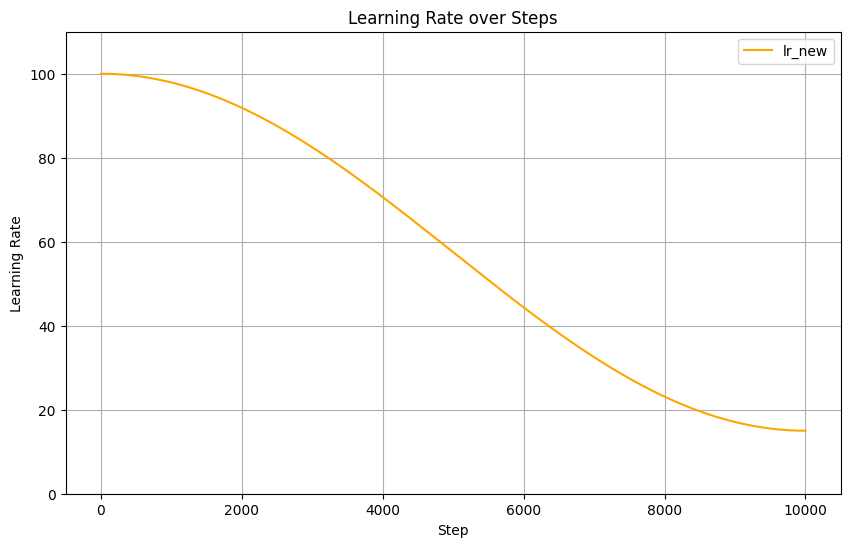

In [12]:
import matplotlib.pyplot as plt
from time import time

# Assuming `schd_old.set_lr(step)` and `schd_new.set_lr(step)` are defined
steps = range(0, 10001)  # Steps from 0 to 1000
start_old = time()
print(f'old took: {time() - start_old}')
start_new = time()
lr_new_values = [schd_new.set_lr(step) for step in steps]
print(f'new took: {time() - start_new}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(steps, lr_new_values, label='lr_new', color='orange')
plt.ylim((0, lr*ratio_lr*1.1))
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.legend()
plt.grid(True)
plt.show()
